# Mines Data Exploration
## Table of Contents
<ul>
    <li><a href='#preliminary_wrangling'>Preliminary Wrangling</a></li>
    <ul>
        <li><a href='#structure_of_dataset'>Structure of Dataset</a></li>  
        <li><a href='#pre_univariate_exploration'>Preliminary Univariate Exploration</a></li>
        <li><a href='#features_of_interest'>Feature of Interest</a></li>
    </ul>
    <li><a href='#active_mines'>Active Mines</a></li>
    <ul>
        <li><a href='#univariate_exploration'>Univariate Exploration</a></li>
    </ul>
</ul>

<a id='preliminary_wrangling'></a>
## Preliminary Wrangling

This section preliminary explores a mine dataset that lists all Coal and Metal/Non-Metal mines under MSHA's jurisdiction since 1/1/1970.

In [6]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import requests

%matplotlib inline

In [7]:
# load in the dataset into a pandas dataframe
mines = pd.read_csv('mines.txt', sep='|', encoding='ISO-8859-1')

In [8]:
# download column definitions and save
url = 'https://arlweb.msha.gov/OpenGovernmentData/DataSets/Mines_Definition_File.txt'
definition_file_name = url.split('/')[-1]

if not os.path.exists(definition_file_name):
    response = requests.get(url)
    with open(os.path.join(definition_file_name),
              mode = 'wb') as file:
        file.write(response.content)

In [9]:
# high-level overview overview of mine data shape and composition
print(mines.shape)
print(mines.info())
mines.head()

(87596, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87596 entries, 0 to 87595
Data columns (total 59 columns):
MINE_ID                        87596 non-null int64
CURRENT_MINE_NAME              87596 non-null object
COAL_METAL_IND                 87596 non-null object
CURRENT_MINE_TYPE              87249 non-null object
CURRENT_MINE_STATUS            87596 non-null object
CURRENT_STATUS_DT              87596 non-null object
CURRENT_CONTROLLER_ID          86558 non-null object
CURRENT_CONTROLLER_NAME        86558 non-null object
CURRENT_OPERATOR_ID            86843 non-null object
CURRENT_OPERATOR_NAME          87596 non-null object
STATE                          87596 non-null object
BOM_STATE_CD                   87596 non-null int64
FIPS_CNTY_CD                   87596 non-null int64
FIPS_CNTY_NM                   87596 non-null object
CONG_DIST_CD                   68869 non-null float64
COMPANY_TYPE                   86843 non-null object
CURRENT_CONTROLLER_BEGIN_DT    86

,MINE_ID,CURRENT_MINE_NAME,COAL_METAL_IND,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,CURRENT_STATUS_DT,CURRENT_CONTROLLER_ID,CURRENT_CONTROLLER_NAME,CURRENT_OPERATOR_ID,CURRENT_OPERATOR_NAME,...,NO_NONPRODUCING_PITS,NO_TAILING_PONDS,PILLAR_RECOVERY_USED,HIGHWALL_MINER_USED,MULTIPLE_PITS,MINERS_REP_IND,SAFETY_COMMITTEE_IND,MILES_FROM_OFFICE,DIRECTIONS_TO_MINE,NEAREST_TOWN
0,100003,O'Neal Quarry & Mill,M,Surface,Active,01/22/1979,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",...,NaN,0.0,N,N,N,N,N,100,Approx 7 miles south of the city of Alabaster ...,Calera
1,100004,Brierfield Quarry,M,Surface,Active,03/04/2003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",...,NaN,0.0,N,N,N,N,N,35,"I-65 SOUTH EXIT US 31 TO CALERA, TURN RIGHT ON...",Brierfield
2,100005,Birmingham Plant,M,Surface,Abandoned,08/15/1989,0041044,Lhoist Group,L10998,Allied Lime Company,...,NaN,NaN,N,N,N,N,N,0,NaN,NaN
3,100006,Auburn Quarry,M,Surface,Active,09/24/1976,NaN,NaN,L16197,"Martin Marietta Materials, Inc.",...,NaN,0.0,N,N,N,N,N,140,85 to Hwy. 29 South to County Rd. 10; turn lef...,Auburn
4,100008,Landmark Plant,M,Surface,Active,11/14/1975,M31753,Alan B Cheney,L31753,Cheney Lime & Cement Company,...,NaN,0.0,N,N,N,N,N,25,I-65 S to exit 238; right on Hwy 31 1/8 miles ...,Alabaster


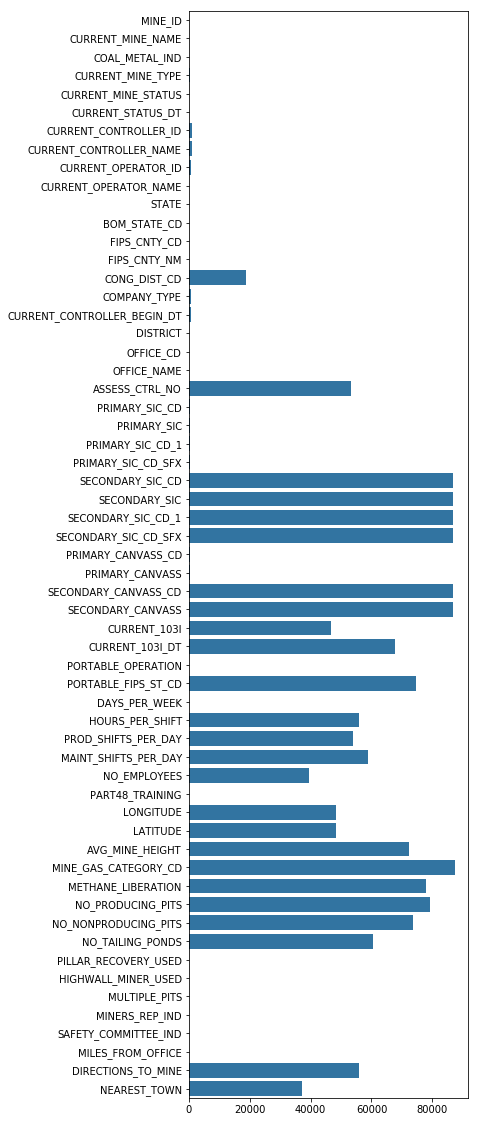

In [10]:
# visualize missing data
plt.figure(figsize=(5,20))
na_counts = mines.isna().sum()
base_color = sb.color_palette()[0]
sb.barplot(na_counts, na_counts.index.values,
           color=base_color);

<a id='structure_of_dataset'></a>
#### Structure of the dataset
There are 87,596 mines in the dataset. Each mine has 59 attributes. From first glance, it seems like not all variables can be used for the analysis. There's about an even balance between numeric and string variables. About half of variables have a lot of missing information. A number of mines have geo location. Upon further look into the columns with missing values along with a definition table for mine variables, a logical reason comes out why a lot of values are missing. Here's the logic:
- CURRENT_CONTROLLER_ID, CURRENT_OPERATOR_ID, CURRENT_OPERATOR_ID: If it's a new mine, current controllers and operators may not have been assigned yet.
- ASSESS_CTRL_NO: the most recent violation or citation and this may not have been tracked at older dates. Also, some newer mines may not have gotten any violations yet.
- SECONDARY_SIC_CD, SECONDARY_SIC, SECONDARY_SIC_CD_1, SECONDARY_SIC_CD_SFX: Not all mines mine more than one resource. Same with having more than one canvas.
- PORTABLE_FIPS_ST_CD: applies only to portable mines.
- AVG_MINE_HEIGHT: applies to coal mines only, but it's still has missing values.
- MINE_GAS_CATEGORY_CD: doesn't apply to all mines. Only for Metal/Non-Metal mines and the surface mills of Subcategory I-C mines (gilsonite) mines.
- METHANE_LIBERATION, NO_PRODUCING_PITS, NO_NONPRODUCING_PITS, NO_TAILING_PONDS: may not apply to all mines.


And there're columns that really have null values. My guess is that it's due to those values not being tracked in earlier years or regulations being less strict. This is something that would be interesting to investigate with data. These columns are:
- CURRENT_103I
- CURRENT_103I_DT
- HOURS_PER_SHIFT
- PROD_SHIFTS_PER_DAY
- MAINT_SHIFTS_PER_DAY
- NO_EMPLOYEES
- LONGITUDE and LATITUDE
- AVG_MINE_HEIGHT
- NO_PRODUCING_PITS
- NO_NONPRODUCING_PITS
- NO_TAILING_PONDS
- DIRECTIONS_TO_MINE
- NEAREST_TOWN

<a id='pre_univariate_exploration'></a>
#### Preliminary Univariate Exploration

I'll start by looking at the distribution of the type of mines. First, coal and non-coal mines.

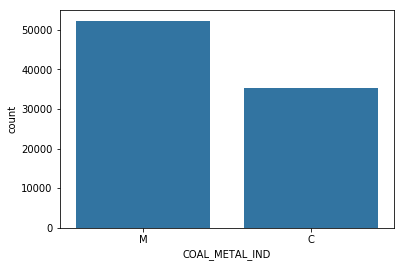

In [11]:
# show a bar plot with total counts for types
base_color = sb.color_palette()[0]
sb.countplot(data = mines, x = 'COAL_METAL_IND', color = base_color);

In total, there're more metal/non-metal mines combined than coal mines. Interestingly, coal mines constitute a big chunk of mines recorded in the dataset.

Next, type of mines.

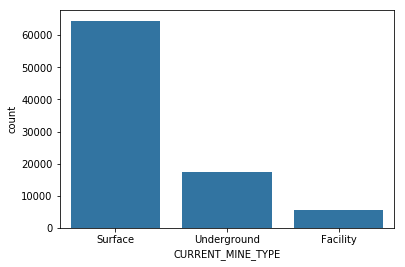

In [12]:
# show a bar plot with total counts for types
sb.countplot(data = mines, x = 'CURRENT_MINE_TYPE', color = base_color);

Most of the mines in the dataset are surface mines. I'm suprised to see so many facility type mines. These are the mines that are used for varous types of research.

Next, current status of the mines.

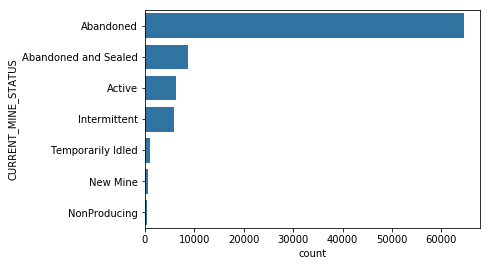

In [13]:
# show a bar plot with total counts for types
cat_order = mines['CURRENT_MINE_STATUS'].value_counts().index
sb.countplot(data = mines, y = 'CURRENT_MINE_STATUS', color = base_color,
             order = cat_order);

Almost all of the mines in the dataset are either abandoned or abandoned and sealed. This indicates that the lifespan of mines is either very short or we're doing less mining today than we did before. This a question worth investigation later. There're about 6,000 thousand active mines and slightly less of intermittent mines. Another question that comes up is where are the intermittent mine located and does the location have something to do with their status (ex. conditions too extreme to operate in certain times of year). There's a small number of temporarily idled mines and even less new mines.

Next, the dates each mine received it's current status.

In [14]:
# convert string values to datetime
mines.CURRENT_STATUS_DT = pd.to_datetime(mines.CURRENT_STATUS_DT)

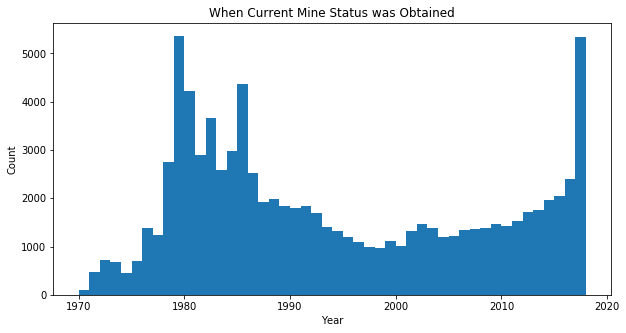

In [15]:
# standard scaled histogram plot
base_year = 1970
year_interval = 1
bin_edges = np.arange(base_year, 
                      mines.CURRENT_STATUS_DT.dt.year.max() + year_interval,
                      year_interval)
plt.figure(figsize=(10,5))
plt.hist(x = mines.CURRENT_STATUS_DT.dt.year, bins = bin_edges)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('When Current Mine Status was Obtained');

The time distriburion looks roughly bimodal, with one peak around 1980, and a second peak in 2017. Interestingly, the peaks have steep jumps. 2017 is the last year we have data for and the sudden jump means there were a lot of changes in the mine statuses lately. The ploted data indicates change, but doesn't indicate if more mines are coming online or more mines are shutting down.

Next, the primary commodities mined.

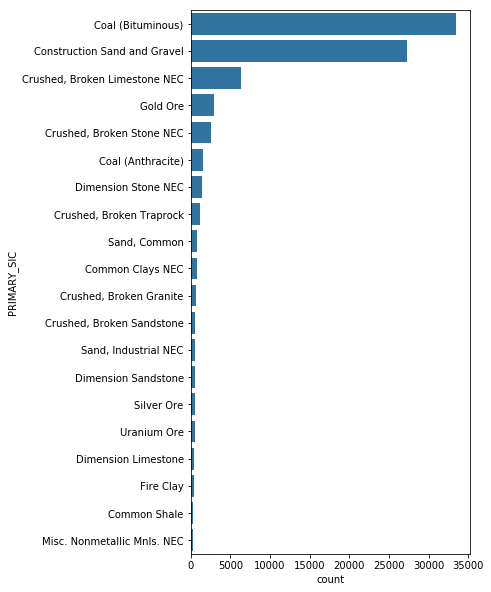

In [16]:
# show a bar plot with total counts for types
plt.figure(figsize=(5,10))
cat_order = mines['PRIMARY_SIC'].value_counts().index[:20]
sb.countplot(data = mines, y = 'PRIMARY_SIC', color = base_color,
             order= cat_order);

The big two resources that account for most of the historic mines are coal and sand/gravel. There're a lot of resources being mined but number of mines for each drop off quickly. Also, it appears that most of the mining operations are to support energy and construction industries.

<a id='features_of_interest'></a>
#### Features of interest in the dataset
After preliminary exploring the whole dataset, it stood out that most of the mines are not in use anymore. Therefore, it would make sense to explore mines that are currently active. My goal is to explore summary statistics and uncover at leat two interesting insights.

<a id='active_mines'></a>
## Active Mines

In this section currently active mines are explored.

In [17]:
# create a dataframe of active ines
mines_active = mines.query('CURRENT_MINE_STATUS == "Active"')

In [18]:
# high-level overview overview of active mines data shape and composition
print(mines_active.shape)
print(mines_active.info())

(6336, 59)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6336 entries, 0 to 87542
Data columns (total 59 columns):
MINE_ID                        6336 non-null int64
CURRENT_MINE_NAME              6336 non-null object
COAL_METAL_IND                 6336 non-null object
CURRENT_MINE_TYPE              6336 non-null object
CURRENT_MINE_STATUS            6336 non-null object
CURRENT_STATUS_DT              6336 non-null datetime64[ns]
CURRENT_CONTROLLER_ID          6193 non-null object
CURRENT_CONTROLLER_NAME        6193 non-null object
CURRENT_OPERATOR_ID            6334 non-null object
CURRENT_OPERATOR_NAME          6336 non-null object
STATE                          6336 non-null object
BOM_STATE_CD                   6336 non-null int64
FIPS_CNTY_CD                   6336 non-null int64
FIPS_CNTY_NM                   6336 non-null object
CONG_DIST_CD                   3151 non-null float64
COMPANY_TYPE                   6334 non-null object
CURRENT_CONTROLLER_BEGIN_DT    6334 non-nul

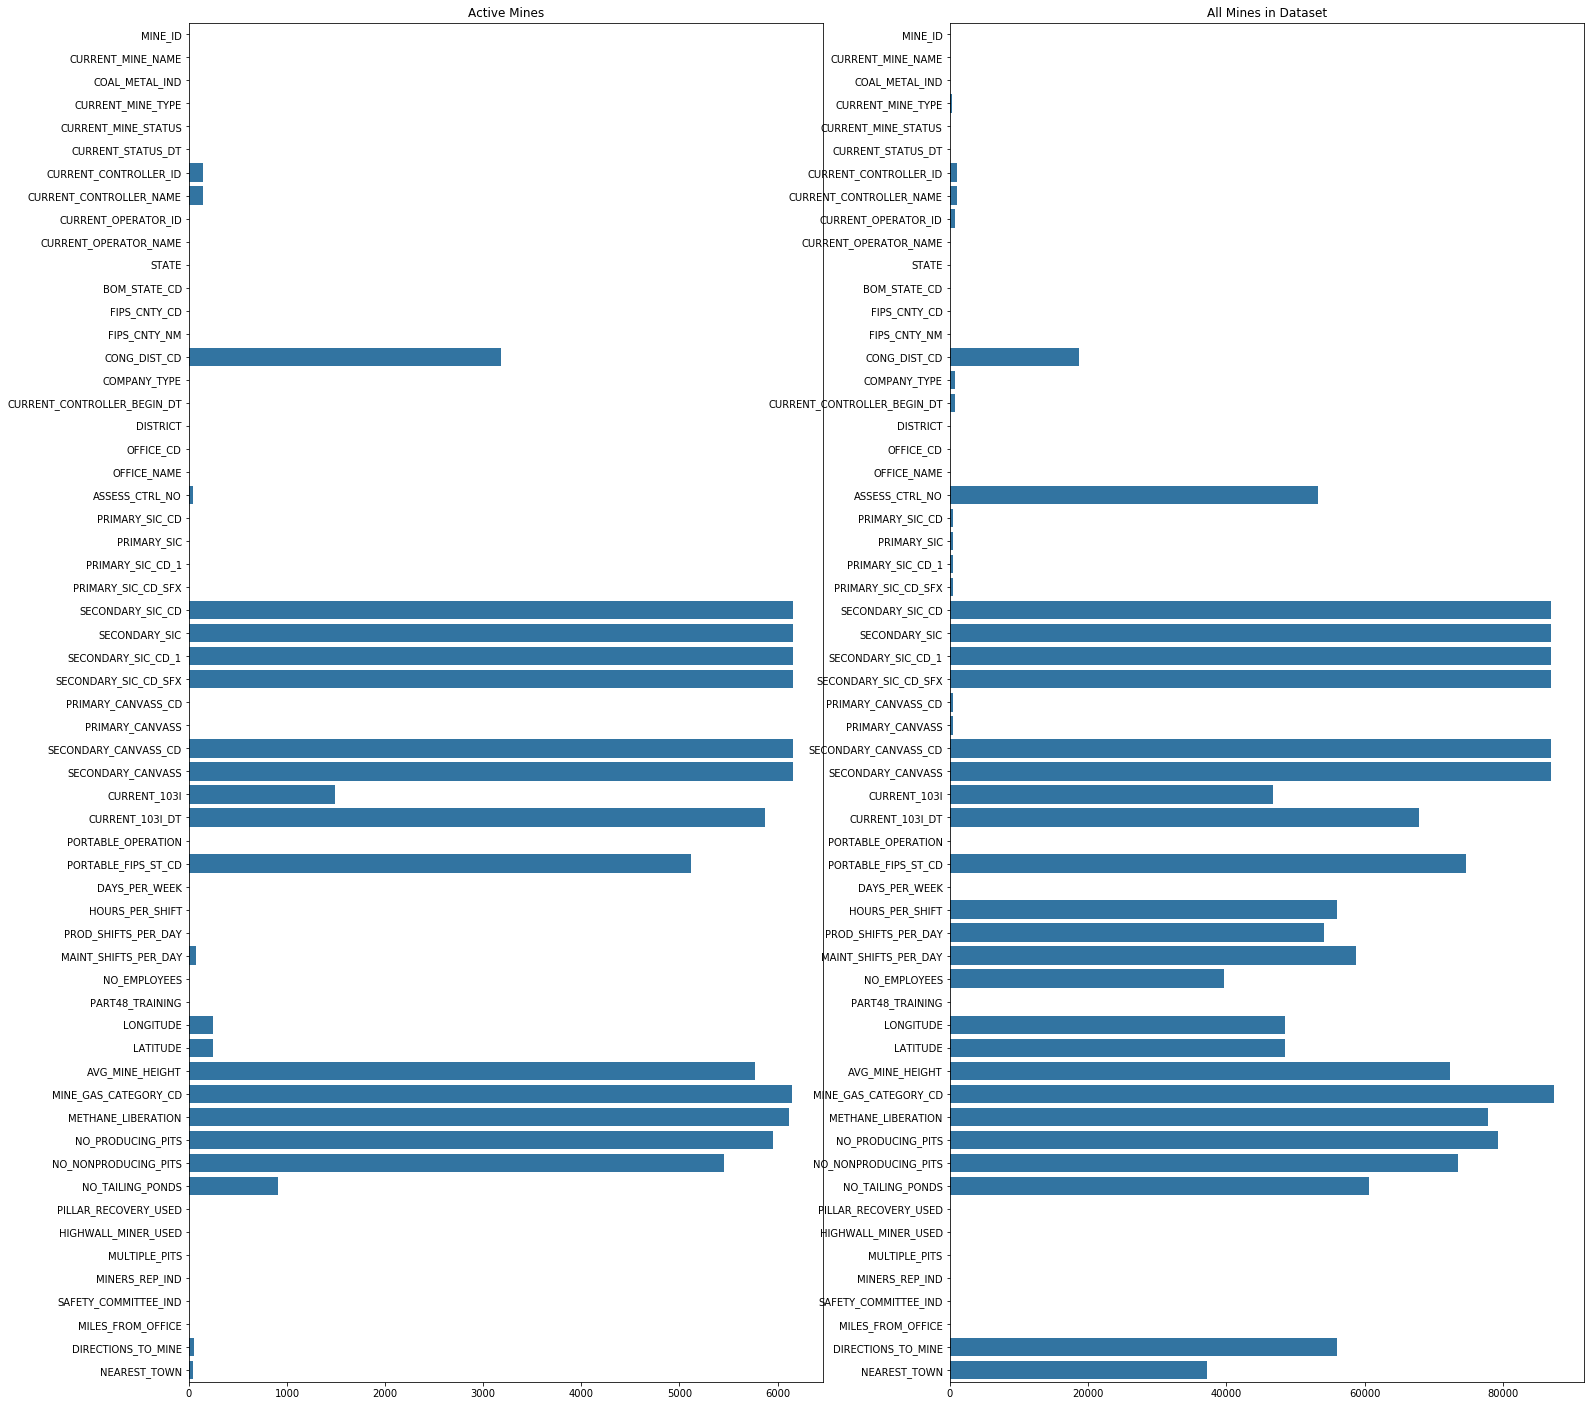

In [19]:
# visualize missing data
plt.figure(figsize=(25,25))
# active mines
plt.subplot(1, 2, 1)
na_counts = mines_active.isna().sum()
base_color = sb.color_palette()[0]
sb.barplot(na_counts, na_counts.index.values,
           color=base_color)
plt.title('Active Mines');

# all mines in dataset
plt.subplot(1, 2, 2)
na_counts = mines.isna().sum()
base_color = sb.color_palette()[0]
sb.barplot(na_counts, na_counts.index.values,
           color=base_color)
plt.title('All Mines in Dataset');

There're 6,336 mines that are currently active. There're less missing values than the whole dataset. This means that the tracking efforts iproved. A small number of mines don't have an operator. I would expect those mines to be new. Almost mines have a geo location. Employee data is not missing. Overall the active mine sub-dataset looks cleaner.

<a id='univariate_exploration'></a>
#### Univariate Exploration

For some plots, to see a change, I'm going to compare information between active mines and all mines in the dataset. The reason I chose 'active mines' and 'all mines in the dataset' instead of 'active mines' and 'non-active' mines is because some mine can be very prolific and operate the whole span of the dataset. And chosing in which dataset those mines would go would skew the data. Again, I'll start by looking at the distribution of the type of mines. First, coal and non-coal mines.

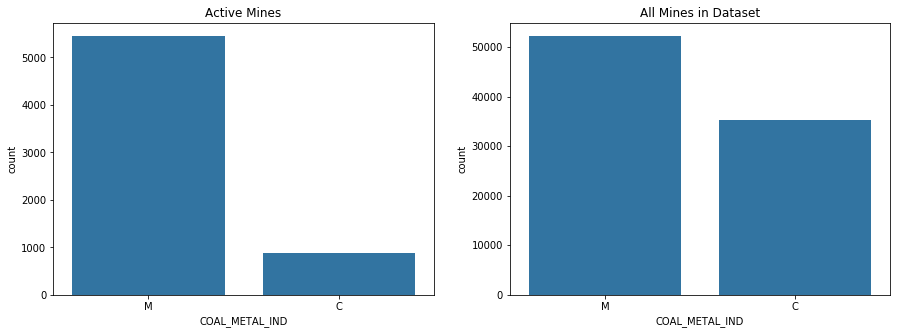

In [20]:
# show a bar plot with total counts for types
plt.figure(figsize=(15,5))
base_color = sb.color_palette()[0]

# active mines
plt.subplot(1, 2, 1)
sb.countplot(data = mines_active, x = 'COAL_METAL_IND', color = base_color)
plt.title('Active Mines')

# all mines in dataset
plt.subplot(1, 2, 2)
sb.countplot(data = mines, x = 'COAL_METAL_IND', color = base_color)
plt.title('All Mines in Dataset');

Fraction of active mines that are coal is much less now. Seems, like we may be doing less coal mining. But this information isn't enough to arrive at that conclusion since we don't have the mine physical outputs data.

Next, type of mines.

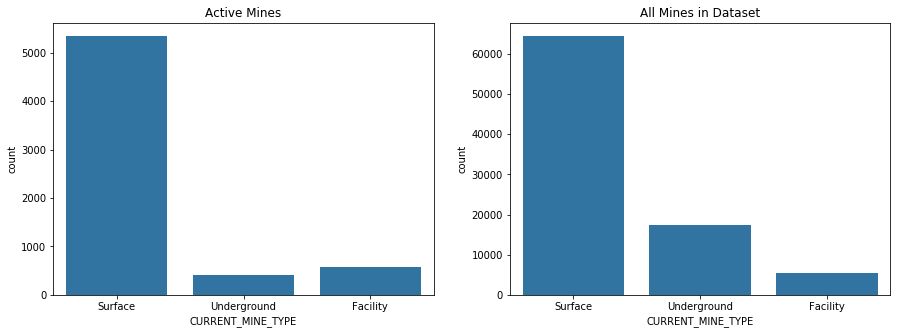

In [21]:
# show a bar plot with total counts for types
plt.figure(figsize=(15,5))

# active mines
plt.subplot(1, 2, 1)
sb.countplot(data = mines_active, x = 'CURRENT_MINE_TYPE', color = base_color);
plt.title('Active Mines');

# all mines in dataset
plt.subplot(1, 2, 2)
sb.countplot(data = mines, x = 'CURRENT_MINE_TYPE', color = base_color);
plt.title('All Mines in Dataset');

The fraction of underground mines is less in the active dataset. This is probably good for working conditions but not so good for the environment. 

Next, lets see the distribution of mine by state.

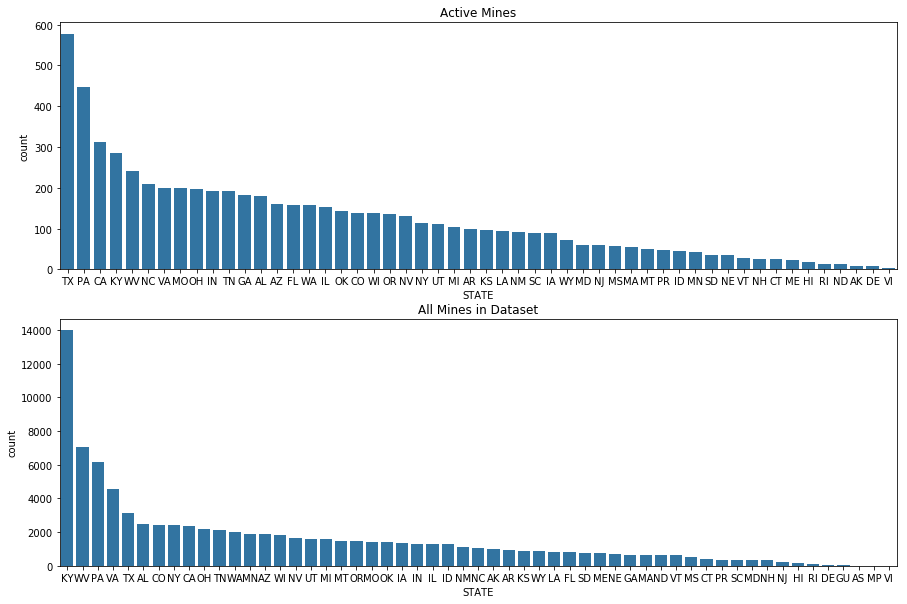

In [46]:
# show bar plots with total counts for each states
plt.figure(figsize=(15,10))

# active mines
plt.subplot(2,1,1)
bar_order = mines_active.STATE.value_counts().index
sb.countplot(data = mines_active, x = 'STATE', color = base_color,
             order = bar_order)
plt.title('Active Mines');

# all mines in dataset
plt.subplot(2,1,2)
bar_order = mines.STATE.value_counts().index
sb.countplot(data = mines, x = 'STATE', color = base_color,
             order = bar_order)
plt.title('All Mines in Dataset');

The distribution has changed. Kentucky isn't number one anymore. The top three with most amount of mines that are currently active are Texas, Pennsylvania, and Kentucky. On the other end with almost no  active mines are Virgin Islands, Alaska, and Delaware. This makes sense due to their size and locations. Also

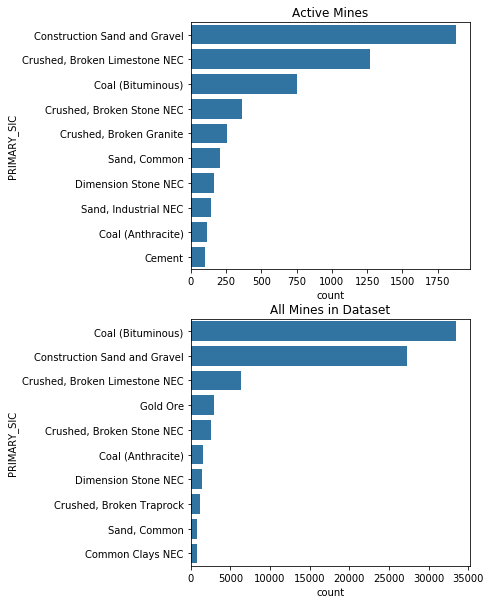

In [40]:
# show bar plots with total counts for each resource
plt.figure(figsize=(5,10))

# active mines
plt.subplot(2,1,1)
bar_order = mines_active.PRIMARY_SIC.value_counts().index[:10]
sb.countplot(data = mines_active, y = 'PRIMARY_SIC', color = base_color,
             order = bar_order)
plt.title('Active Mines');

# all mines in dataset
plt.subplot(2,1,2)
bar_order = mines.PRIMARY_SIC.value_counts().index[:10]
sb.countplot(data = mines, y = 'PRIMARY_SIC', color = base_color,
             order = bar_order)
plt.title('All Mines in Dataset');

Coal mines are not the top mines anymore. The top three resources for mines are construction sand, limestone, and then coal. It's interesting to note that gold ore is not in the top ten anymore.

Next, how many days per wee the mines operate.

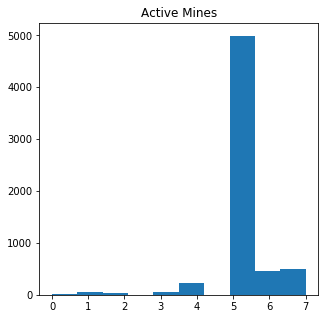

In [56]:
# plot distributions of days per week 
plt.figure(figsize=(5,5))
plt.hist(mines_active.DAYS_PER_WEEK)
plt.title('Active Mines');

In [57]:
# show number of employess for mines with 0 operating days per week
mines_active[mines_active.DAYS_PER_WEEK == 0].NO_EMPLOYEES

11358      4.0
11383      8.0
11388     17.0
11412     54.0
11447    124.0
11546     46.0
11675    138.0
64322      NaN
64346      NaN
67731      7.0
Name: NO_EMPLOYEES, dtype: float64

Most of the mines operate five days a week. With a small fraction operating six and seven days. Some of the active mines were recorded as operating zero days a week. Eight of those mines have employees. If I was MSHA, I would check on those locations.

Next, what's the distribution of shifts per day?

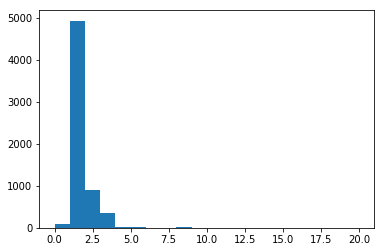

In [65]:
# plot distributions of shifts per day
bin_size = 1
bin_edges = np.arange(min(mines_active['PROD_SHIFTS_PER_DAY']),
                 max(mines_active['PROD_SHIFTS_PER_DAY']) + bin_size,
                 bin_size)
plt.hist(data = mines_active, x = 'PROD_SHIFTS_PER_DAY', bins = bin_edges);

The initial plot of shifts per day shows some immediate point of attention. Most of the data is set to the far left, suggesting some strong outliers on the right. Also, there're some mines with zero shifts per day. Usually, the max number of shifts in a day is three. It's worth taking a bit of time to identify those strange observation. 

In [94]:
# print the strange observations
outliers = (mines_active['PROD_SHIFTS_PER_DAY'] < 1) | \
            (mines_active['PROD_SHIFTS_PER_DAY'] > 3)
#explore
mines_active[outliers].iloc[:,6:12]

,CURRENT_CONTROLLER_ID,CURRENT_CONTROLLER_NAME,CURRENT_OPERATOR_ID,CURRENT_OPERATOR_NAME,STATE,BOM_STATE_CD
1968,0073991,Rodney Mays,0156433,"Mays Mining, Inc.",AL,1
2336,0101481,"Piney Woods Resources, Inc",0126573,"Jesse Creek Mining, LLC",AL,1
2367,M00452,Rogers Group Inc,L06514,Rogers Group Inc,AL,1
5126,0100847,Jimmy S Lovell,0118849,Cossatot Rock LLC,AR,3
5269,0109701,Danny Hansbrough; Steve Philpot,0129033,"Custom Crushing, LLC",AR,3
5562,M00004,Heidelberg Cement AG,L36376,Mission Valley Rock,CA,4
5584,M09149,Cemex S A,0103149,"CEMEX Construction Materials Pacific, LLC",CA,4
5759,0118443,Earl G Broderick,0139153,Nuns Canyon Rock LLC,CA,4
5762,M09149,Cemex S A,0103149,"CEMEX Construction Materials Pacific, LLC",CA,4
8383,M06183,CRH PLC,L16678,Four Corners Materials,CO,5
